In [42]:
import pandas as pd
import os
import sqlite3

In [21]:
Fitbit_dir = "./Fitbit_05042022/ShiYangLee/Physical Activity/heart_rate-2022-03-29.json"

In [22]:
df_fitbit = pd.read_json(Fitbit_dir)

In [23]:
df_fitbit.head()

,dateTime,value
0,2022-03-28 23:00:06,"{'bpm': 56, 'confidence': 3}"
1,2022-03-28 23:00:21,"{'bpm': 56, 'confidence': 3}"
2,2022-03-28 23:00:31,"{'bpm': 57, 'confidence': 3}"
3,2022-03-28 23:00:41,"{'bpm': 58, 'confidence': 3}"
4,2022-03-28 23:00:46,"{'bpm': 57, 'confidence': 3}"


In [24]:
df_fitbit.value.dtype

dtype('O')

In [25]:
df_fitbit.isnull().sum()

dateTime    0
value       0
dtype: int64

In [29]:
def data_split(data):
    if 'value' not in data.columns:
        print("The dataframe is already splitted!")
        return
    data['value'] = data['value'].astype('str')
    tmp = data.value.str.split(' ', expand = True)
    data[['bpm', 'confidence']] = tmp[[1, 3]]
    strip_col = ['bpm', 'confidence']
    data[strip_col] = data[strip_col].apply(lambda x: x.str.strip(",} "))
    print(data)
    data.drop("value", axis = 1, inplace = True)
    print(data)

In [30]:
data_split(df_fitbit)

The dataframe is already splitted!


In [31]:
df_fitbit

,dateTime,bpm,confidence
0,2022-03-28 23:00:06,56,3
1,2022-03-28 23:00:21,56,3
2,2022-03-28 23:00:31,57,3
3,2022-03-28 23:00:41,58,3
4,2022-03-28 23:00:46,57,3
...,...,...,...
11351,2022-03-29 22:59:38,75,3
11352,2022-03-29 22:59:43,79,2
11353,2022-03-29 22:59:48,73,2
11354,2022-03-29 22:59:53,68,3


In [40]:
!ls ./HealthData/DBs

fitbit.db	      garmin.db		    garmin_summary.db  summary.db
garmin_activities.db  garmin_monitoring.db  mshealth.db


In [55]:
garmin_db = "./HealthData/DBs/garmin.db"
con = sqlite3.connect(garmin_db)
cur = con.cursor()
table = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", con)
table

,name
0,_attributes
1,attributes
2,devices
3,weight
4,stress
5,sleep
6,sleep_events
7,resting_hr
8,daily_summary
9,files


In [96]:
garmin_df = pd.read_sql_query("SELECT * FROM resting_hr", con)
garmin_df.head()

,day,resting_heart_rate
0,2022-03-27,67.0
1,2022-03-24,52.0
2,2022-04-02,60.0
3,2022-03-26,52.0
4,2022-03-29,50.0


In [72]:
garmin_monit_db = "./HealthData/DBs/garmin_monitoring.db"
garmin_monit_con = sqlite3.connect(garmin_monit_db)
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", garmin_monit_con)

,name
0,_attributes
1,monitoring_info
2,monitoring_hr
3,monitoring_intensity
4,monitoring_climb
5,monitoring
6,monitoring_rr
7,monitoring_pulse_ox


In [78]:
info = pd.read_sql_query("SELECT * FROM monitoring_info", garmin_monit_con)
info

,timestamp,file_id,activity_type,resting_metabolic_rate,cycles_to_distance,cycles_to_calories
0,2022-03-24 18:20:00.000000,129844478804,walking,1876,1.5924,0.036258
1,2022-03-24 18:20:00.000000,129844478804,running,1876,2.3886,0.114551
2,2022-03-26 13:11:00.000000,130084718422,walking,1876,1.5924,0.036258
3,2022-03-26 13:11:00.000000,130084718422,running,1876,2.3886,0.114551
4,2022-03-31 03:51:00.000000,130761492107,walking,1876,1.5924,0.036258
...,...,...,...,...,...,...
549,2022-04-05 19:25:00.000000,131522625880,running,1876,2.3886,0.114551
550,2022-03-25 22:17:00.000000,129999621058,walking,1876,1.5924,0.036258
551,2022-03-25 22:17:00.000000,129999621058,running,1876,2.3886,0.114551
552,2022-04-02 10:35:00.000000,131033327923,walking,1876,1.5924,0.036258


In [76]:
garmin_hr = pd.read_sql_query("SELECT * FROM monitoring_hr", garmin_monit_con)
garmin_hr

,timestamp,heart_rate
0,2022-03-24 18:21:00.000000,72
1,2022-03-26 13:13:00.000000,72
2,2022-03-26 13:14:00.000000,73
3,2022-03-26 13:18:00.000000,72
4,2022-03-26 13:19:00.000000,73
...,...,...
13911,2022-04-02 10:48:00.000000,60
13912,2022-04-02 10:49:00.000000,62
13913,2022-04-02 10:50:00.000000,60
13914,2022-04-02 10:51:00.000000,69


In [95]:
garmin_0329_hr = garmin_hr.loc[(garmin_hr['timestamp'] >= '2022-03-29') & \
                               (garmin_hr['timestamp'] < '2022-03-30')]
garmin_0329_hr.set_index('timestamp')

,heart_rate
timestamp,
2022-03-29 09:29:00.000000,117
2022-03-29 09:30:00.000000,123
2022-03-29 09:31:00.000000,110
2022-03-29 09:32:00.000000,97
2022-03-29 09:33:00.000000,92
...,...
2022-03-29 23:56:00.000000,55
2022-03-29 23:57:00.000000,56
2022-03-29 23:58:00.000000,57


<AxesSubplot:xlabel='timestamp', ylabel='heart_rate'>

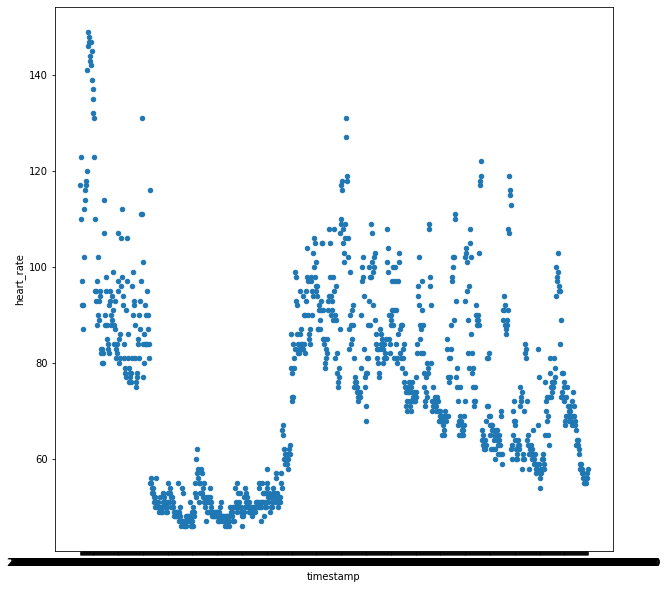

In [103]:
garmin_0329_hr.plot(x = 'timestamp', y = 'heart_rate', kind = 'scatter', figsize = (10,10))